# Part A: Implement AlexNet - Winner of ILSVRC 2012 (10 points)

## Overview

AlexNet, a significant milestone in the resurgence of deep learning, made a remarkable impact by winning the ILSVRC 2012 competition. This assignment focuses on implementing the original AlexNet architecture using PyTorch.

## Task Description

### Implementation of AlexNet

- **Objective**: Implement the original AlexNet model as described in its seminal paper.
- **Architecture Details**: The model should be consistent with the architecture specified in the original paper, but with adjustments for modern GPU capabilities and correct input size.

### Key Points to Note

1. **Input Size Correction**: The model should use an RGB image input of size 227 × 227 × 3, correcting the 224 × 224 × 3 mistake mentioned in the original figure.
2. **Hardware Optimization**: Unlike the original implementation, there's no need to split convolutions across two GPU cards due to improved hardware.
3. **Existing Implementations**: While many AlexNet implementations exist online (e.g., in the torchvision library), they often contain modifications. It is crucial to understand and appropriately adjust these versions to align with the original AlexNet design.
4. **PyTorch Modules**: Utilize built-in PyTorch modules such as `torch.nn.Conv2d`, `torch.nn.Linear`, `torch.nn.ReLU`, and `torch.nn.Dropout`.
5. **Starter Code and Dataset**: Starter code and data loader scripts are provided, including the `PACSDataset` class for handling images from different domains and classes.
6. **Function Signature**: Maintain the provided function signature without alterations.

### Additional Instructions

1. **Starter Code**: Download the starter code from Canvas and integrate it into a Colab notebook.
2. **Model Training**: Complete the AlexNet implementation and train the model for the domain prediction task.
3. **Hyperparameter Tuning**: Adjust hyperparameters to optimize performance.
4. **Reporting**: Document the model architecture and accuracy on the validation set in the notebook.

### Dataset Details

- **Dataset**: The dataset consists of 9991 images across 4 domains (art painting, cartoon, photo, sketch) and 7 classes (dog, elephant, giraffe, guitar, horse, house, person), addressing the domain shift problem.
- **Dual Labels**: Each image is labeled for both class and domain, selectable via the `label_type` flag.
- **Dataset Source**: Download the images from the provided link and refer to the detailed dataset description for further insights.

### Python Environment Requirements

Ensure the following packages are installed in the Python environment: matplotlib, seaborn, torch, absl-py, scikit-image, tensorboard, torchvision, tqdm.



In [1]:
import zipfile
import os

# File path for the uploaded dataset
zip_file_path = '/content/pacs_dataset.zip'
extracted_folder_path = '/content/pacs_dataset'

# Extracting the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Confirming the extraction
extracted_files = os.listdir(extracted_folder_path)
extracted_files

['pacs_dataset']

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from skimage import io
import os

class AlexNet(nn.Module):
    def __init__(self, num_classes=4):  # Assuming 4 domains for the domain prediction task
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Creating an instance of AlexNet for the domain prediction task
alexnet_model = AlexNet()
print(alexnet_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [3]:
import collections
import copy
import os

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from absl import app, flags
from skimage import io
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm import tqdm

FLAGS = flags.FLAGS

flags.DEFINE_enum('task_type', 'training', ['training', 'analysis'],
                  'Specifies the task type.')

# Hyperparameters for Part I
flags.DEFINE_float('learning_rate', 1e-3, 'Learning rate.')
flags.DEFINE_float('weight_decay', 0, 'Weight decay (L2 regularization).')
flags.DEFINE_integer('batch_size', 128, 'Number of examples per batch.')
flags.DEFINE_integer('epochs', 100, 'Number of epochs for training.')
flags.DEFINE_string('experiment_name', 'exp', 'Defines experiment name.')
flags.DEFINE_enum('label_type', 'domain', ['domain', 'category'],
                  'Specifies prediction task.')

# Hyperparemeters for Part III
flags.DEFINE_string('model_checkpoint', '',
                    'Specifies the checkpont for analyzing.')

LABEL_SIZE = {'domain': 4, 'category': 7}


class PACSDataset(Dataset):

  def __init__(self,
               root_dir,
               label_type='domain',
               is_training=False,
               transform=None):
    self.root_dir = os.path.join(root_dir, 'train' if is_training else 'val')
    self.label_type = label_type
    self.is_training = is_training
    if transform:
      self.transform = transform
    else:
      self.transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.7659, 0.7463, 0.7173],
                               std=[0.3089, 0.3181, 0.3470]),
      ])

    self.dataset, self.label_list = self.initialize_dataset()
    self.label_to_id = {x: i for i, x in enumerate(self.label_list)}
    self.id_to_label = {i: x for i, x in enumerate(self.label_list)}

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    image, label = self.dataset[idx]
    label_id = self.label_to_id[label]
    image = self.transform(image)
    return image, label_id

  def initialize_dataset(self):
    assert os.path.isdir(self.root_dir), \
        '`root_dir` is not found at %s' % self.root_dir

    dataset = []
    domain_set = set()
    category_set = set()
    cnt = 0

    for root, dirs, files in os.walk(self.root_dir, topdown=True):
      if files:
        _, domain, category = root.rsplit('/', maxsplit=2)
        domain_set.add(domain)
        category_set.add(category)
        pbar = tqdm(files)
        for name in pbar:
          pbar.set_description('Processing Folder: domain=%s, category=%s' %
                               (domain, category))
          img_array = io.imread(os.path.join(root, name))
          dataset.append((img_array, domain, category))

    images, domains, categories = zip(*dataset)

    if self.label_type == 'domain':
      labels = sorted(domain_set)
      dataset = list(zip(images, domains))
    elif self.label_type == 'category':
      labels = sorted(category_set)
      dataset = list(zip(images, categories))
    else:
      raise ValueError(
          'Unknown `label_type`: Expecting `domain` or `category`.')

    return dataset, labels


# class AlexNet(nn.Module):

#   def __init__(self, configs):
#     super().__init__()
#     self.configs = configs
#     raise NotImplementedError

#   def forward(self, x):
#     raise NotImplementedError


class AlexNetLargeKernel(nn.Module):

  def __init__(self, configs):
    super().__init__()
    self.configs = configs
    raise NotImplementedError

  def forward(self, x):
    raise NotImplementedError


class AlexNetAvgPooling(nn.Module):

  def __init__(self, configs):
    super().__init__()
    self.configs = configs
    raise NotImplementedError

  def forward(self, x):
    raise NotImplementedError


def visualize_kernels(kernel_name,
                      kernel_weight,
                      max_in_channels=12,
                      max_out_channels=12,
                      saving_prefix='kernel'):
  """A helper function to visualize the learned convolutional kernels.

  Args:
    kernel_name: str, the name of the kernel being visualized. It will be used
        as the filename in the saved figures.
    kernel_weight: torch.Tensor or np.ndarray, the weights of convolutional
        kernel. The shape should be
        [out_channels, in_channels, kernel_height, kernel_width].
    max_in_channels: int, optional, the max in_channels in the visualization.
    max_out_channels: int, optional, the max out_channels in the visualization.
    saving_prefix: str, optional, the directory for saving the visualization.
  """
  print('Visualize the learned filter of `%s`' % kernel_name)
  if isinstance(kernel_weight, torch.Tensor):
    kernel_weight = kernel_weight.cpu().numpy()

  kernel_shape = list(kernel_weight.shape)

  nrows = min(max_in_channels, kernel_shape[1])
  ncols = min(max_out_channels, kernel_shape[0])

  fig, axes = plt.subplots(nrows, ncols, figsize=(ncols, nrows))

  for r in range(nrows):
    for c in range(ncols):
      kernel = kernel_weight[c, r, :, :]
      vmin, vmax = kernel.min(), kernel.max()
      normalized_kernel = (kernel - vmin) / (vmax - vmin)
      sns.heatmap(normalized_kernel,
                  cbar=False,
                  square=True,
                  xticklabels=False,
                  yticklabels=False,
                  ax=axes[r, c])

  plt.xlabel('First %d In-Channels' % nrows)
  plt.ylabel('First %d Out-Channels' % ncols)

  plt.tight_layout()
  plt.savefig(os.path.join(saving_prefix, kernel_name.lower() + '.png'))
  return


def analyze_model_kernels():
  raise NotImplementedError


def model_training():
  train_dataset = PACSDataset(root_dir='pacs_dataset',
                              label_type=FLAGS.label_type,
                              is_training=True)
  train_loader = DataLoader(train_dataset,
                            batch_size=FLAGS.batch_size,
                            shuffle=True,
                            num_workers=4)

  val_dataset = PACSDataset(root_dir='pacs_dataset',
                            label_type=FLAGS.label_type,
                            is_training=False)
  val_loader = DataLoader(val_dataset,
                          batch_size=FLAGS.batch_size,
                          shuffle=False,
                          num_workers=4)

  best_model = None
  best_acc = 0.0

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

  experiment_name = 'experiments/{}/{}_lr_{}.wd_{}'.format(
      FLAGS.experiment_name, FLAGS.label_type, FLAGS.learning_rate,
      FLAGS.weight_decay)

  os.makedirs(experiment_name, exist_ok=True)
  writer = SummaryWriter(log_dir=experiment_name)

  configs = {'num_classes': LABEL_SIZE[FLAGS.label_type]}

  ############################################################################
  """After implementing all required models, you can switch from here."""
#   model = AlexNet(configs).to(device)
  # model = AlexNetLargeKernel(configs).to(device)
  # model = AlexNetAvgPooling(configs).to(device)
  ############################################################################

  print('Model Architecture:\n%s' % model)

  criterion = nn.CrossEntropyLoss(reduction='mean')
  optimizer = torch.optim.Adam(model.parameters(),
                               lr=FLAGS.learning_rate,
                               weight_decay=FLAGS.weight_decay)

  try:
    for epoch in range(FLAGS.epochs):
      for phase in ('train', 'eval'):
        if phase == 'train':
          model.train()
          dataset = train_dataset
          data_loader = train_loader
        else:
          model.eval()
          dataset = val_dataset
          data_loader = val_loader

        running_loss = 0.0
        running_corrects = 0

        for step, (images, labels) in enumerate(data_loader):
          images = images.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()

          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            if phase == 'train':
              loss.backward()
              optimizer.step()

              writer.add_scalar('Loss/{}'.format(phase), loss.item(),
                                epoch * len(data_loader) + step)

          running_loss += loss.item() * images.size(0)
          running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataset)
        epoch_acc = running_corrects.double() / len(dataset)
        writer.add_scalar('Epoch_Loss/{}'.format(phase), epoch_loss, epoch)
        writer.add_scalar('Epoch_Accuracy/{}'.format(phase), epoch_acc, epoch)
        print('[Epoch %d] %s accuracy: %.4f, loss: %.4f' %
              (epoch + 1, phase, epoch_acc, epoch_loss))

        if phase == 'eval':
          if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model = copy.deepcopy(model.state_dict())
            torch.save(best_model, os.path.join(experiment_name,
                                                'best_model.pt'))

  except KeyboardInterrupt:
    pass

  return


In [4]:
from torchvision import transforms

# Preparing the dataset
root_dir = '/content/pacs_dataset/pacs_dataset'  # Adjusted path to the extracted dataset
label_type = 'domain'  # For domain prediction task

# Creating transformations for the dataset
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7659, 0.7463, 0.7173], std=[0.3089, 0.3181, 0.3470]),
])

# Creating the dataset instances for training and validation
train_dataset = PACSDataset(root_dir=root_dir, label_type=label_type, is_training=True, transform=transform)
val_dataset = PACSDataset(root_dir=root_dir, label_type=label_type, is_training=False, transform=transform)

# DataLoader for training and validation sets
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Proceeding to the training phase
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_classes = LABEL_SIZE[label_type]
model = AlexNet(num_classes=num_classes).to(device)

# Training parameters
learning_rate = 1e-3
weight_decay = 0
epochs = 50  # Reduced the number of epochs for quicker demonstration

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Let's train the model for a few epochs to demonstrate the process
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, save_path='model_checkpoint.pth'):
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            data_loader = train_loader if phase == 'train' else val_loader
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # Save the best model checkpoint
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': best_model_wts,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': epoch_loss,
                    'accuracy': epoch_acc,
                }, save_path)

    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

save_path = "/content/pacs_dataset/alexnet.pth"
# Train the model
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, save_path)

print("Model trained and saved.")

Processing Folder: domain=art_painting, category=dog: 100%|██████████| 348/348 [00:01<00:00, 257.87it/s]
Processing Folder: domain=art_painting, category=giraffe: 100%|██████████| 254/254 [00:01<00:00, 194.03it/s]
Processing Folder: domain=art_painting, category=horse: 100%|██████████| 179/179 [00:01<00:00, 119.90it/s]
Processing Folder: domain=art_painting, category=elephant: 100%|██████████| 227/227 [00:00<00:00, 271.24it/s]
Processing Folder: domain=art_painting, category=guitar: 100%|██████████| 169/169 [00:00<00:00, 282.60it/s]
Processing Folder: domain=art_painting, category=person: 100%|██████████| 404/404 [00:01<00:00, 274.09it/s]
Processing Folder: domain=art_painting, category=house: 100%|██████████| 262/262 [00:00<00:00, 271.96it/s]
Processing Folder: domain=sketch, category=dog: 100%|██████████| 697/697 [00:02<00:00, 262.94it/s]
Processing Folder: domain=sketch, category=giraffe: 100%|██████████| 681/681 [00:02<00:00, 286.88it/s]
Processing Folder: domain=sketch, category=h

Epoch 1/50
----------
train Loss: 3.6869 Acc: 0.3914
val Loss: 0.9149 Acc: 0.5768
Epoch 2/50
----------
train Loss: 0.7097 Acc: 0.6651
val Loss: 0.5612 Acc: 0.7116
Epoch 3/50
----------
train Loss: 0.5260 Acc: 0.7432
val Loss: 0.4371 Acc: 0.7573
Epoch 4/50
----------
train Loss: 0.5101 Acc: 0.7608
val Loss: 0.5147 Acc: 0.7396
Epoch 5/50
----------
train Loss: 0.6559 Acc: 0.7201
val Loss: 0.5274 Acc: 0.7562
Epoch 6/50
----------
train Loss: 0.5100 Acc: 0.7554
val Loss: 0.4592 Acc: 0.7977
Epoch 7/50
----------
train Loss: 0.4622 Acc: 0.7949
val Loss: 0.4096 Acc: 0.8143
Epoch 8/50
----------
train Loss: 0.4002 Acc: 0.8191
val Loss: 0.3699 Acc: 0.8247
Epoch 9/50
----------
train Loss: 0.3626 Acc: 0.8409
val Loss: 0.3400 Acc: 0.8558
Epoch 10/50
----------
train Loss: 0.3535 Acc: 0.8479
val Loss: 0.3627 Acc: 0.8268
Epoch 11/50
----------
train Loss: 0.3255 Acc: 0.8591
val Loss: 0.3358 Acc: 0.8651
Epoch 12/50
----------
train Loss: 0.3109 Acc: 0.8744
val Loss: 0.3084 Acc: 0.8766
Epoch 13/50
-

In [5]:

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Proceeding to the training phase
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_classes = LABEL_SIZE[label_type]
model = AlexNet(num_classes=num_classes).to(device)

# Training parameters
learning_rate = 3e-3
weight_decay = 0
epochs = 50  # Reduced the number of epochs for quicker demonstration


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Train the model
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, save_path)

print("Model trained and saved.")

Epoch 1/50
----------
train Loss: 67.4807 Acc: 0.4259
val Loss: 1.1430 Acc: 0.3475
Epoch 2/50
----------
train Loss: 0.8346 Acc: 0.6282
val Loss: 0.7820 Acc: 0.6878
Epoch 3/50
----------
train Loss: 0.7429 Acc: 0.6986
val Loss: 0.6923 Acc: 0.6981
Epoch 4/50
----------
train Loss: 0.6900 Acc: 0.7162
val Loss: 0.7287 Acc: 0.7137
Epoch 5/50
----------
train Loss: 0.6743 Acc: 0.7224
val Loss: 0.6625 Acc: 0.7054
Epoch 6/50
----------
train Loss: 0.6534 Acc: 0.7291
val Loss: 0.6567 Acc: 0.7127
Epoch 7/50
----------
train Loss: 0.7885 Acc: 0.7051
val Loss: 0.8679 Acc: 0.6836
Epoch 8/50
----------
train Loss: 0.7068 Acc: 0.7048
val Loss: 0.6655 Acc: 0.6888
Epoch 9/50
----------
train Loss: 0.6367 Acc: 0.7297
val Loss: 0.5865 Acc: 0.7282
Epoch 10/50
----------
train Loss: 0.5828 Acc: 0.7616
val Loss: 0.5333 Acc: 0.7749
Epoch 11/50
----------
train Loss: 0.5118 Acc: 0.7829
val Loss: 0.4785 Acc: 0.7593
Epoch 12/50
----------
train Loss: 0.4958 Acc: 0.7903
val Loss: 0.4833 Acc: 0.7873
Epoch 13/50


In [6]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Proceeding to the training phase
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_classes = LABEL_SIZE[label_type]
model = AlexNet(num_classes=num_classes).to(device)

# Training parameters
learning_rate = 5e-4
weight_decay = 0
epochs = 50


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Train the model
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, save_path)

print("Model trained and saved.")

Epoch 1/50
----------
train Loss: 0.8297 Acc: 0.6130
val Loss: 0.4702 Acc: 0.7728
Epoch 2/50
----------
train Loss: 0.4418 Acc: 0.7921
val Loss: 0.3950 Acc: 0.8361
Epoch 3/50
----------
train Loss: 0.3862 Acc: 0.8341
val Loss: 0.3608 Acc: 0.8340
Epoch 4/50
----------
train Loss: 0.4617 Acc: 0.8164
val Loss: 0.4044 Acc: 0.8029
Epoch 5/50
----------
train Loss: 0.4032 Acc: 0.8295
val Loss: 0.3664 Acc: 0.8589
Epoch 6/50
----------
train Loss: 0.3412 Acc: 0.8567
val Loss: 0.3457 Acc: 0.8434
Epoch 7/50
----------
train Loss: 0.3134 Acc: 0.8680
val Loss: 0.3009 Acc: 0.8807
Epoch 8/50
----------
train Loss: 0.2973 Acc: 0.8789
val Loss: 0.3253 Acc: 0.8527
Epoch 9/50
----------
train Loss: 0.2746 Acc: 0.8929
val Loss: 0.2686 Acc: 0.8932
Epoch 10/50
----------
train Loss: 0.2553 Acc: 0.8992
val Loss: 0.2770 Acc: 0.8817
Epoch 11/50
----------
train Loss: 0.2470 Acc: 0.9027
val Loss: 0.2822 Acc: 0.8869
Epoch 12/50
----------
train Loss: 0.2316 Acc: 0.9104
val Loss: 0.2843 Acc: 0.8890
Epoch 13/50
-

# Part B: Enhancing AlexNet (10 points)

## Overview

This section involves modifying the previously implemented AlexNet model. The focus is on training different versions of AlexNet with specific architectural changes. The modifications are designed to explore the effects of different kernel sizes and pooling strategies.

## Task Description

### 1. Larger Kernel Size - AlexNetLargeKernel

#### Modifications:
- **Objective**: Modify the first, second, and fifth convolutional layers of AlexNet to use larger kernels and strides, thereby achieving downsampling without MaxPool2d layers.
- **New Class**: Implement these changes in a new class named `AlexNetLargeKernel`.

#### Instructions:
- **Implementation**: Use the architecture provided below for `AlexNetLargeKernel`.
- **Training**: Train the model with the same optimal hyperparameters as in Part A.
- **Reporting**: Document the architecture and accuracy of `AlexNetLargeKernel` in your report.

### 2. Pooling Strategies - AlexNetAvgPooling

#### Modifications:
- **Objective**: Replace MaxPool2d layers in AlexNet with AvgPool2d layers, which average all neurons in the receptive field.
- **New Class**: Implement these changes in a new class named `AlexNetAvgPooling`.

#### Instructions:
- **Implementation**: Follow the provided architecture for `AlexNetAvgPooling`.
- **Training**: Train the model using the same optimal hyperparameters as in Part A.
- **Reporting**: Report the architecture and accuracy of `AlexNetAvgPooling` in a text snippet in your notebook.

### AlexNetAvgPooling Architecture

```text
class AlexNetAvgPooling
================================================================================================================
    Layer (type)      Kernel      Padding      Stride      Dilation          Output Shape           Param #
----------------------------------------------------------------------------------------------------------------
        Conv2d-1     11 x 11                        4                    [-1, 96, 55, 55]            34,944
          ReLU-2                                                         [-1, 96, 55, 55]                 0
     AvgPool2d-3           3                        2                    [-1, 96, 27, 27]                 0
        Conv2d-4       5 x 5            2                               [-1, 256, 27, 27]           614,656
          ReLU-5                                                        [-1, 256, 27, 27]                 0
     AvgPool2d-6           3                        2                   [-1, 256, 13, 13]                 0
        Conv2d-7       3 x 3            1                               [-1, 384, 13, 13]           885,120
          ReLU-8                                                        [-1, 384, 13, 13]                 0
        Conv2d-9       3 x 3            1                               [-1, 384, 13, 13]         1,327,488
         ReLU-10                                                        [-1, 384, 13, 13]                 0
       Conv2d-11       3 x 3            1                               [-1, 256, 13, 13]           884,992
         ReLU-12                                                        [-1, 256, 13, 13]                 0
    AvgPool2d-13           3                        2                     [-1, 256, 6, 6]                 0
      Flatten-14                                                               [-1, 9216]                 0
      Dropout-15                                                               [-1, 9216]                 0
       Linear-16                                                               [-1, 4096]        37,752,832
         ReLU-17                                                               [-1, 4096]                 0
      Dropout-18                                                               [-1, 4096]                 0
       Linear-19                                                               [-1, 4096]        16,781,312
         ReLU-20                                                               [-1, 4096]                 0
       Linear-21                                                                  [-1, 4]            16,388
================================================================================================================


In [7]:
class AlexNetAvgPooling(nn.Module):
    def __init__(self, num_classes=4):  # Assuming 4 domains for the domain prediction task
        super(AlexNetAvgPooling, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),  # Adjusted the number of output channels to 96
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3, stride=2),  # Replaced MaxPool2d with AvgPool2d
            nn.Conv2d(96, 256, kernel_size=5, padding=2),  # Adjusted the number of output channels to 256
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3, stride=2),  # Replaced MaxPool2d with AvgPool2d
            nn.Conv2d(256, 384, kernel_size=3, padding=1),  # Number of output channels is 384
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),  # Number of output channels adjusted to 384
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # Kept the number of output channels as 256
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3, stride=2),  # Replaced MaxPool2d with AvgPool2d
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))  # This layer remains the same
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),  # Assuming the flattened features have the same size as the original
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Proceeding to the training phase
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_classes = LABEL_SIZE[label_type]
model = AlexNetAvgPooling(num_classes=num_classes).to(device)

# Training parameters
learning_rate = 5e-4
weight_decay = 0
epochs = 50


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

save_path = "/content/pacs_dataset/AlexNetAvgPooling.pth"
# Train the model
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, save_path)

print("Model trained and saved.")

Epoch 1/50
----------
train Loss: 0.7953 Acc: 0.6582
val Loss: 0.5069 Acc: 0.7272
Epoch 2/50
----------
train Loss: 0.5423 Acc: 0.7527
val Loss: 0.5070 Acc: 0.7510
Epoch 3/50
----------
train Loss: 0.4648 Acc: 0.7922
val Loss: 0.4107 Acc: 0.8226
Epoch 4/50
----------
train Loss: 0.4586 Acc: 0.8179
val Loss: 0.4756 Acc: 0.8071
Epoch 5/50
----------
train Loss: 0.3810 Acc: 0.8427
val Loss: 0.3534 Acc: 0.8548
Epoch 6/50
----------
train Loss: 0.3489 Acc: 0.8606
val Loss: 0.3321 Acc: 0.8683
Epoch 7/50
----------
train Loss: 0.3758 Acc: 0.8475
val Loss: 0.3809 Acc: 0.8434
Epoch 8/50
----------
train Loss: 0.3357 Acc: 0.8664
val Loss: 0.3252 Acc: 0.8776
Epoch 9/50
----------
train Loss: 0.3313 Acc: 0.8692
val Loss: 0.4035 Acc: 0.8392
Epoch 10/50
----------
train Loss: 0.3135 Acc: 0.8769
val Loss: 0.3000 Acc: 0.8849
Epoch 11/50
----------
train Loss: 0.2698 Acc: 0.8899
val Loss: 0.3109 Acc: 0.8807
Epoch 12/50
----------
train Loss: 0.2674 Acc: 0.8896
val Loss: 0.3067 Acc: 0.8714
Epoch 13/50
-

In [17]:
def visualize_kernels(kernel_name, kernel_weight, max_in_channels=12, max_out_channels=12, saving_prefix='kernel'):
    print('Visualizing the learned filters of `%s`' % kernel_name)
    if isinstance(kernel_weight, torch.Tensor):
        kernel_weight = kernel_weight.cpu().numpy()

    kernel_shape = list(kernel_weight.shape)
    nrows = min(max_in_channels, kernel_shape[1])
    ncols = min(max_out_channels, kernel_shape[0])

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols, nrows))

    for r in range(nrows):
        for c in range(ncols):
            kernel = kernel_weight[c, r, :, :]
            vmin, vmax = kernel.min(), kernel.max()
            normalized_kernel = (kernel - vmin) / (vmax - vmin)
            sns.heatmap(normalized_kernel, cbar=False, square=True, xticklabels=False, yticklabels=False, ax=axes[r, c])

    plt.xlabel('First %d In-Channels' % nrows)
    plt.ylabel('First %d Out-Channels' % ncols)
    plt.tight_layout()
    plt.show()


AlexNet
Visualizing the learned filters of `Conv Layer 1`


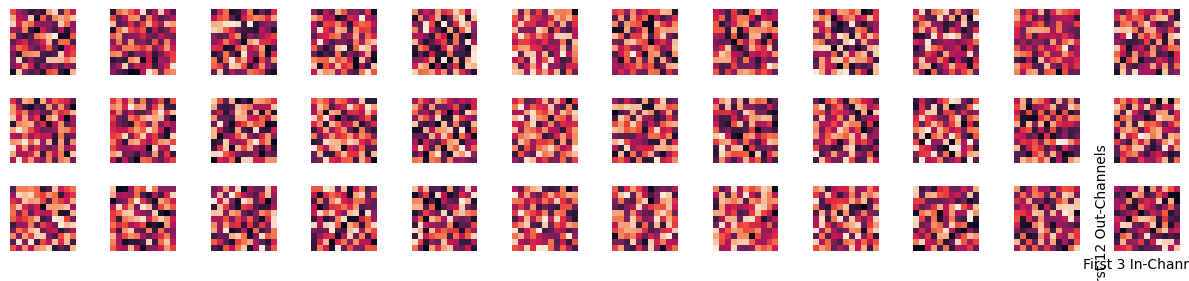

Visualizing the learned filters of `Conv Layer 2`


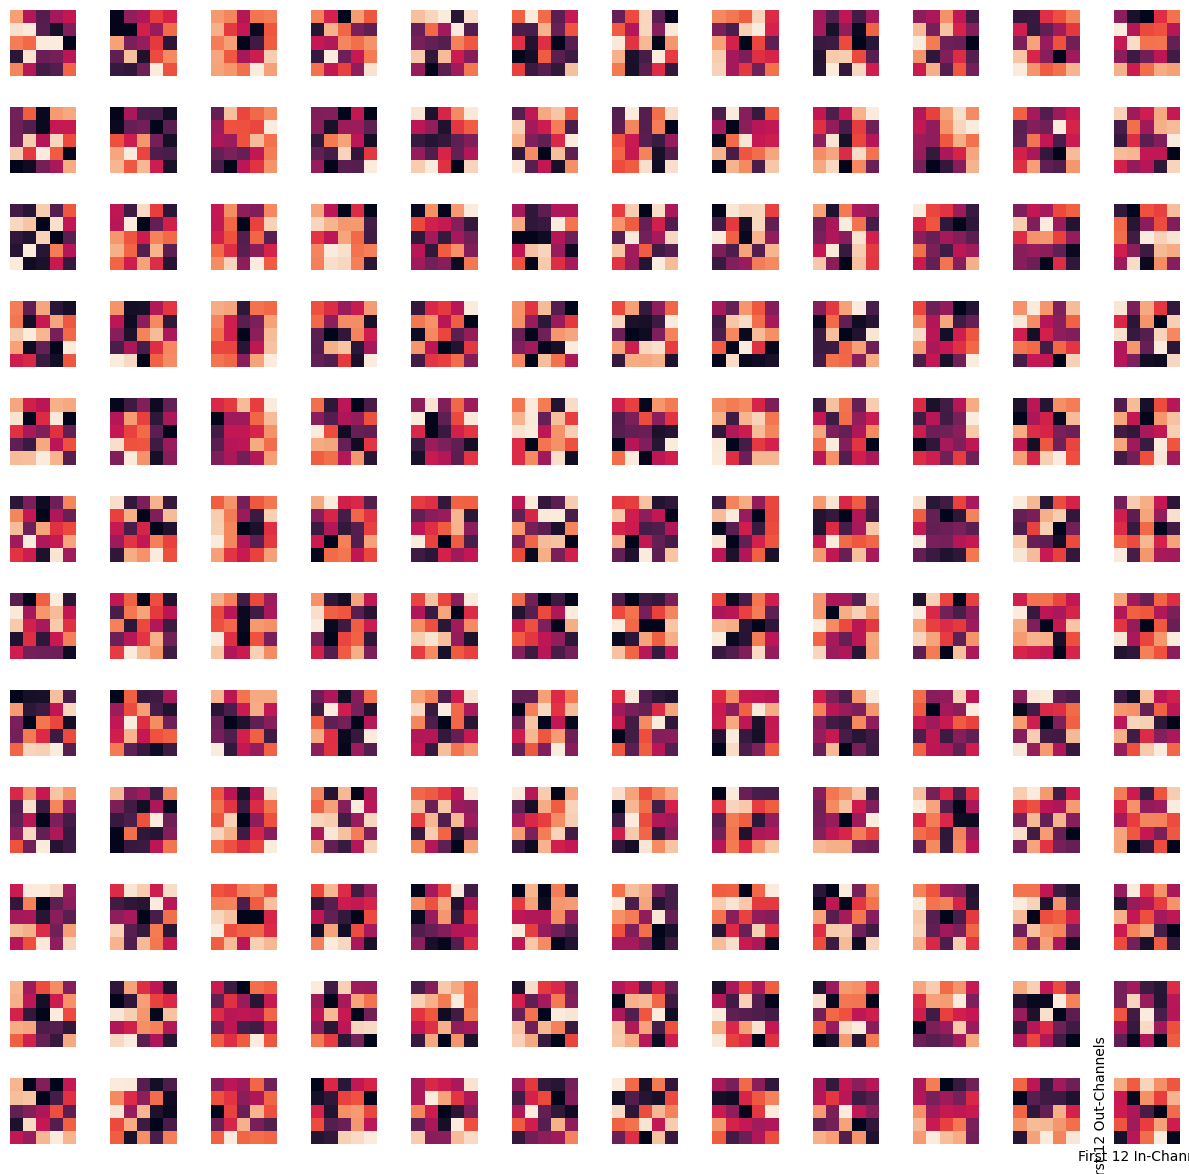

Visualizing the learned filters of `Conv Layer 3`


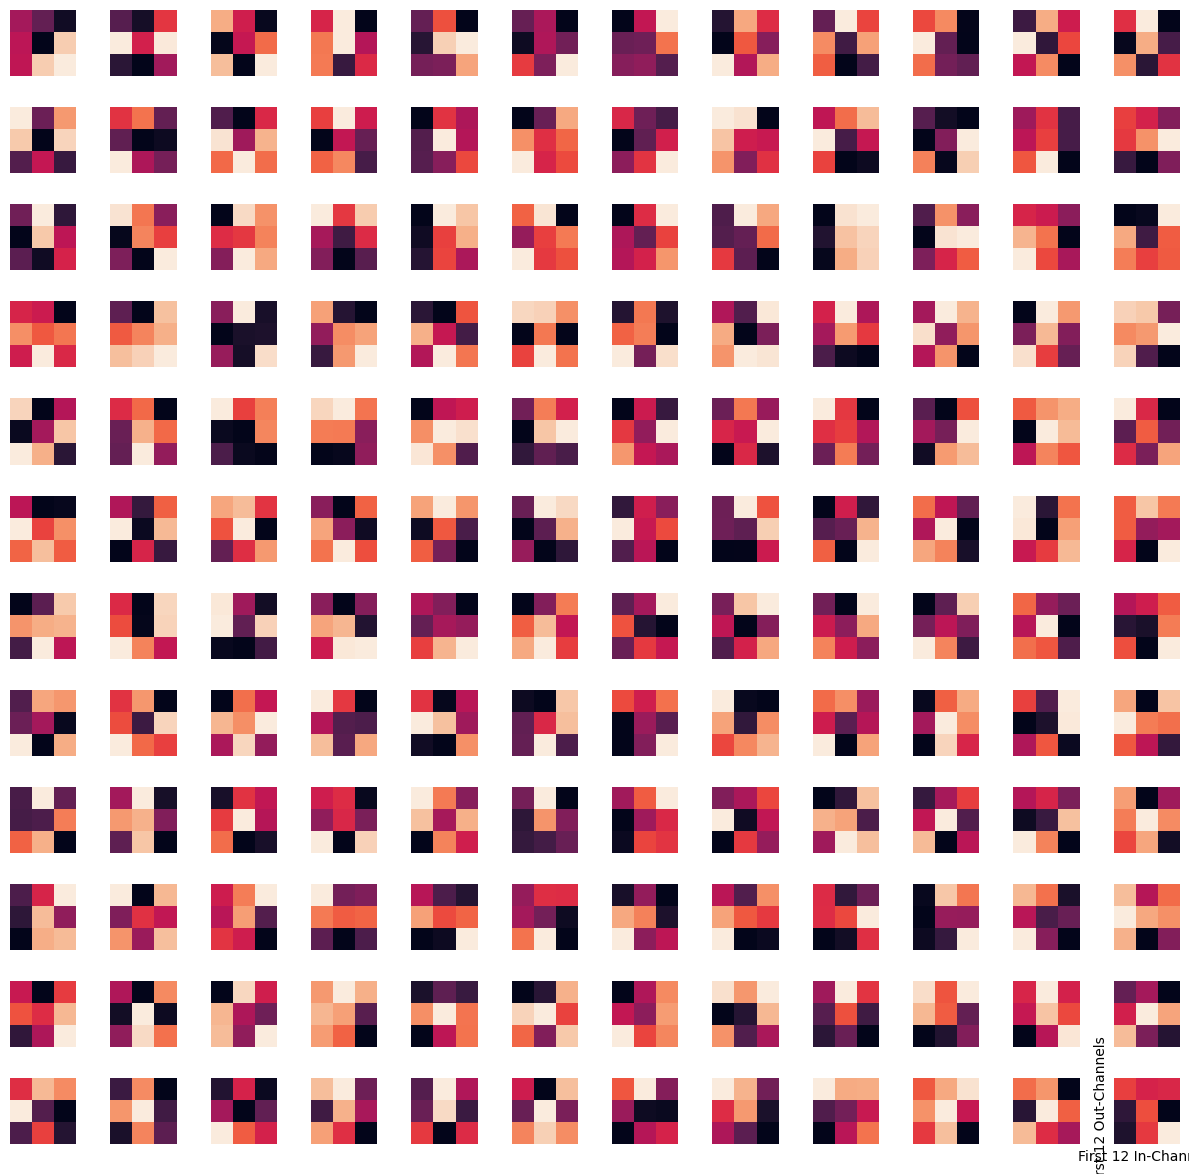

Visualizing the learned filters of `Conv Layer 4`


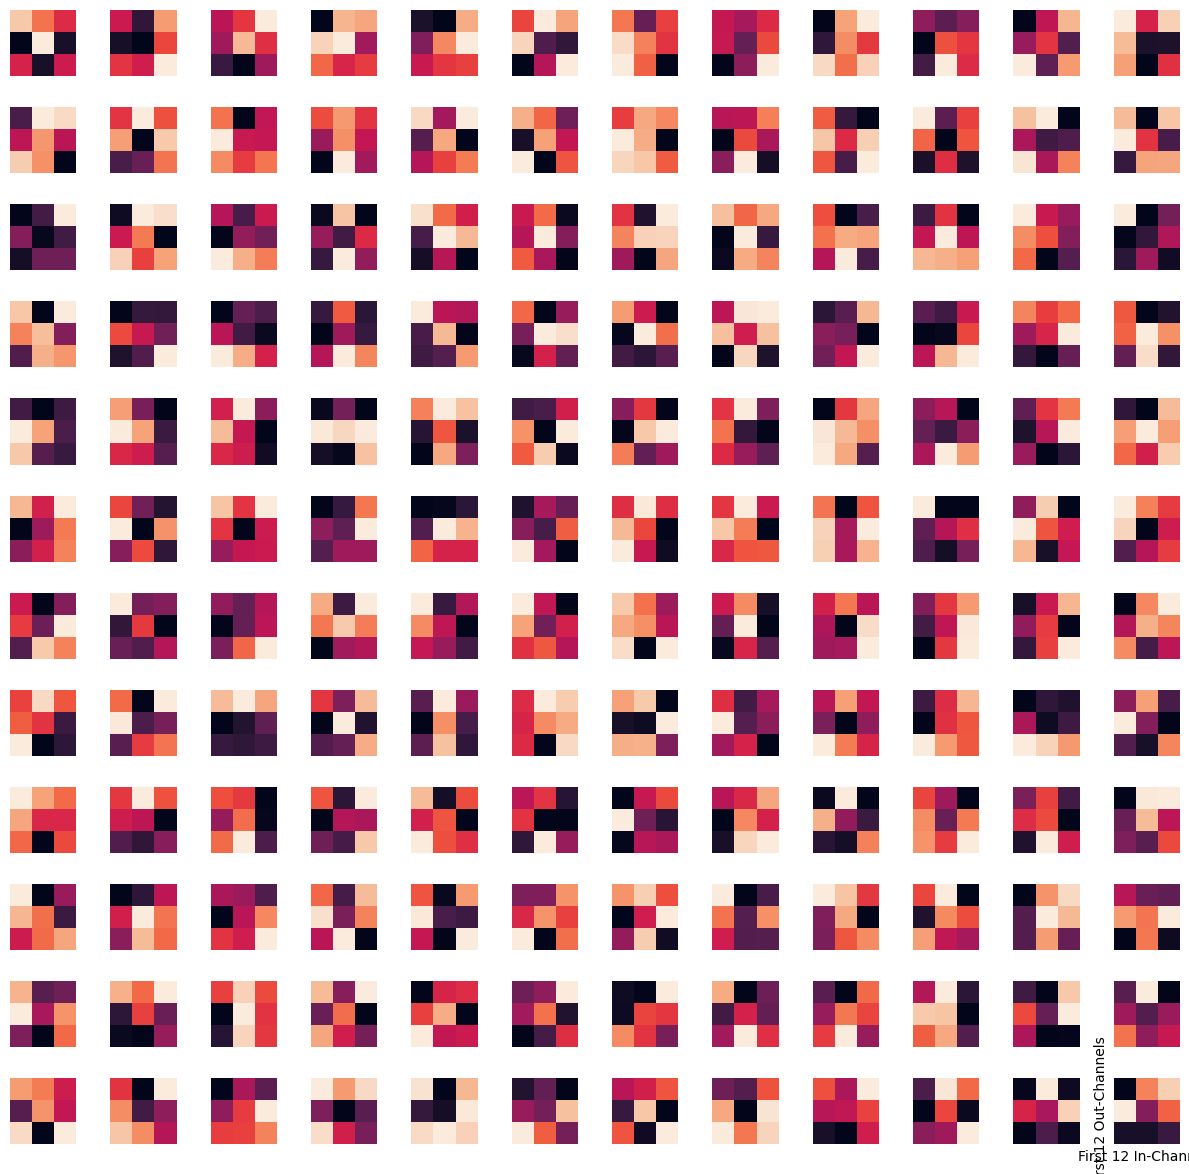

Visualizing the learned filters of `Conv Layer 5`


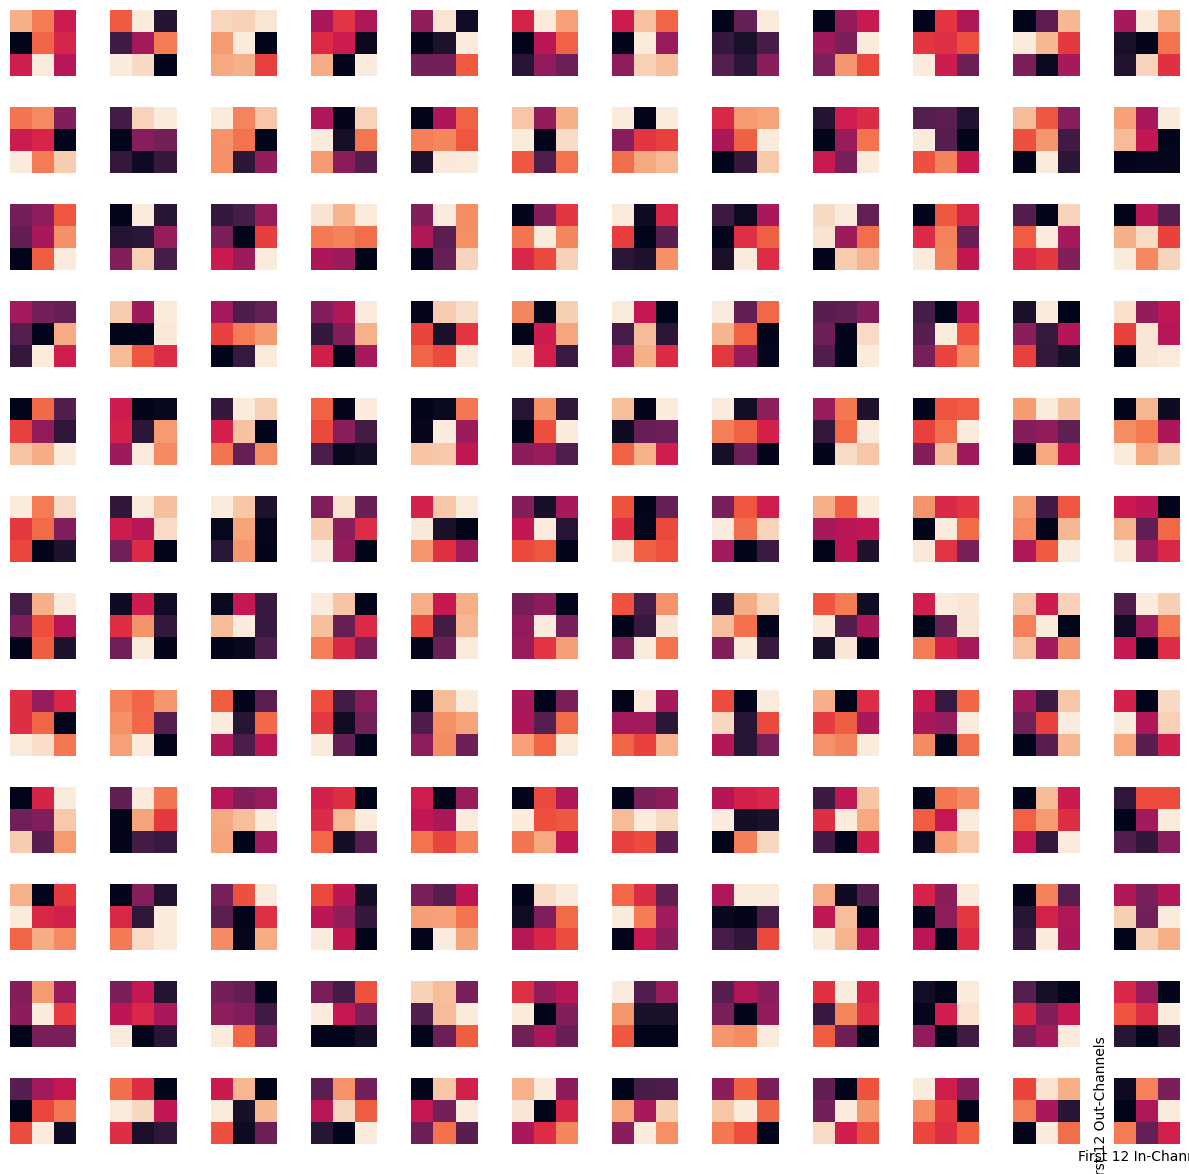

AlexNetAvgPooling


RuntimeError: ignored

In [18]:
def analyze_model_kernels_alex(model_checkpoint_path, num_classes):
    # Load the trained model checkpoint
    checkpoint = torch.load(model_checkpoint_path)

    # Assume the model is an instance of AlexNet or a subclass of it with the same architecture
    model = AlexNet(num_classes)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Extract the kernels from the convolutional layers
    kernels = [model.features[i].weight.data for i in range(len(model.features)) if isinstance(model.features[i], nn.Conv2d)]

    # Use the provided visualization helper function to visualize the kernels
    for i, kernel in enumerate(kernels):
        visualize_kernels(f"Conv Layer {i+1}", kernel)

print("AlexNet")
analyze_model_kernels_alex("/content/pacs_dataset/alexnet.pth", num_classes)


AlexNetAvgPooling
Visualizing the learned filters of `Conv Layer 1`


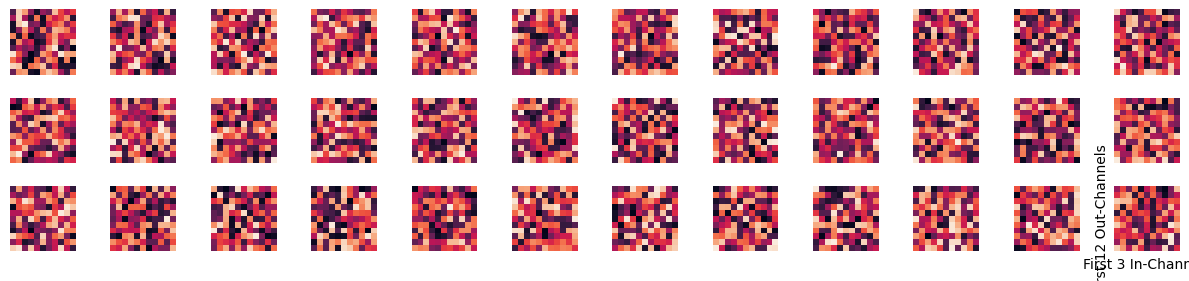

Visualizing the learned filters of `Conv Layer 2`


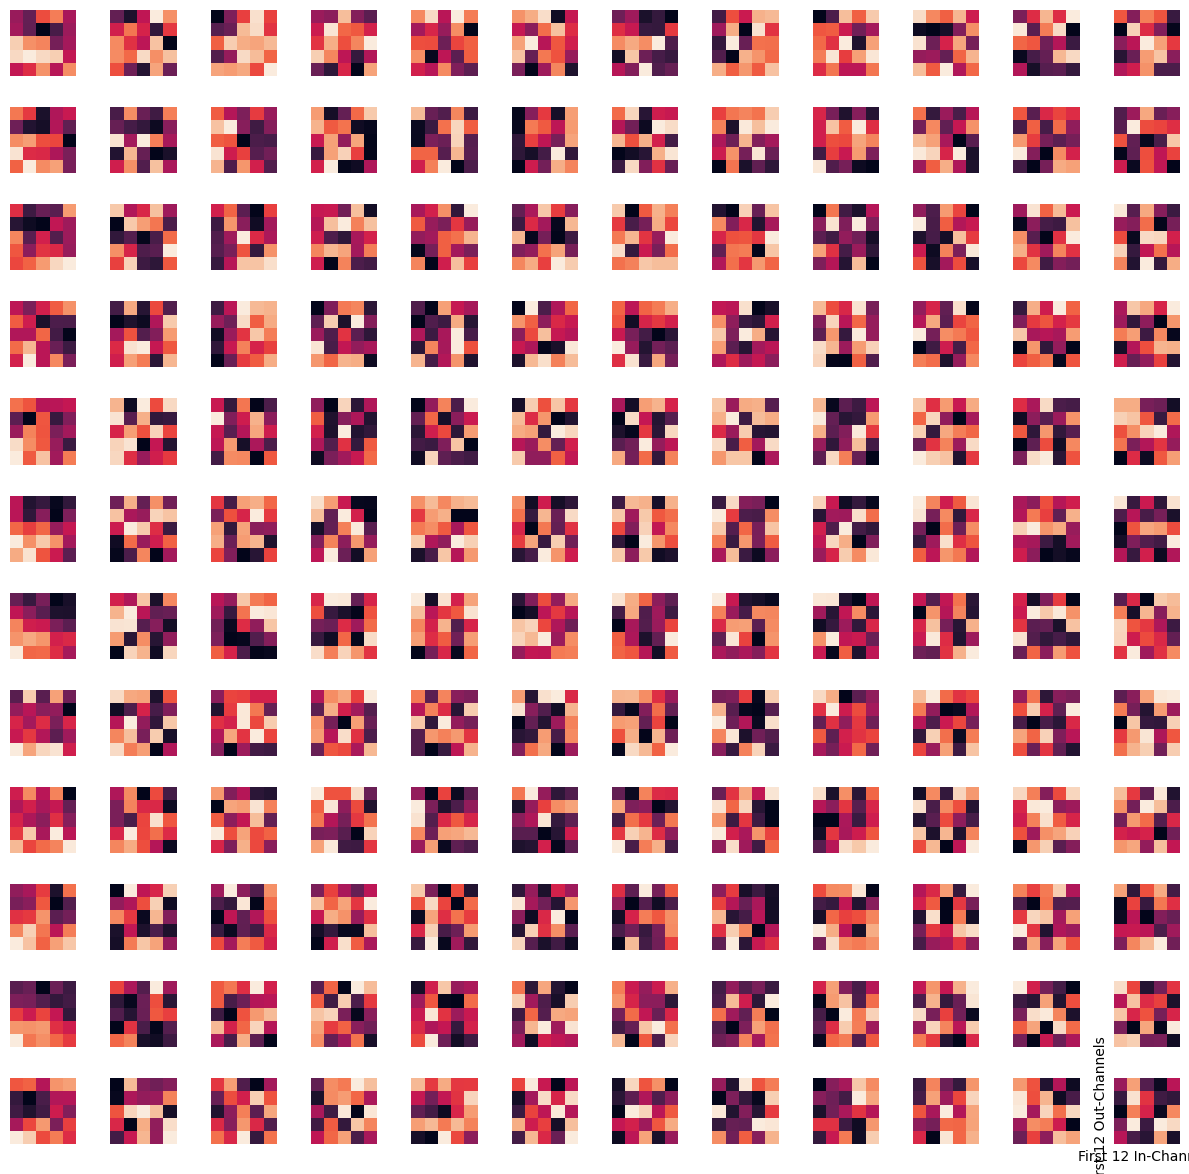

Visualizing the learned filters of `Conv Layer 3`


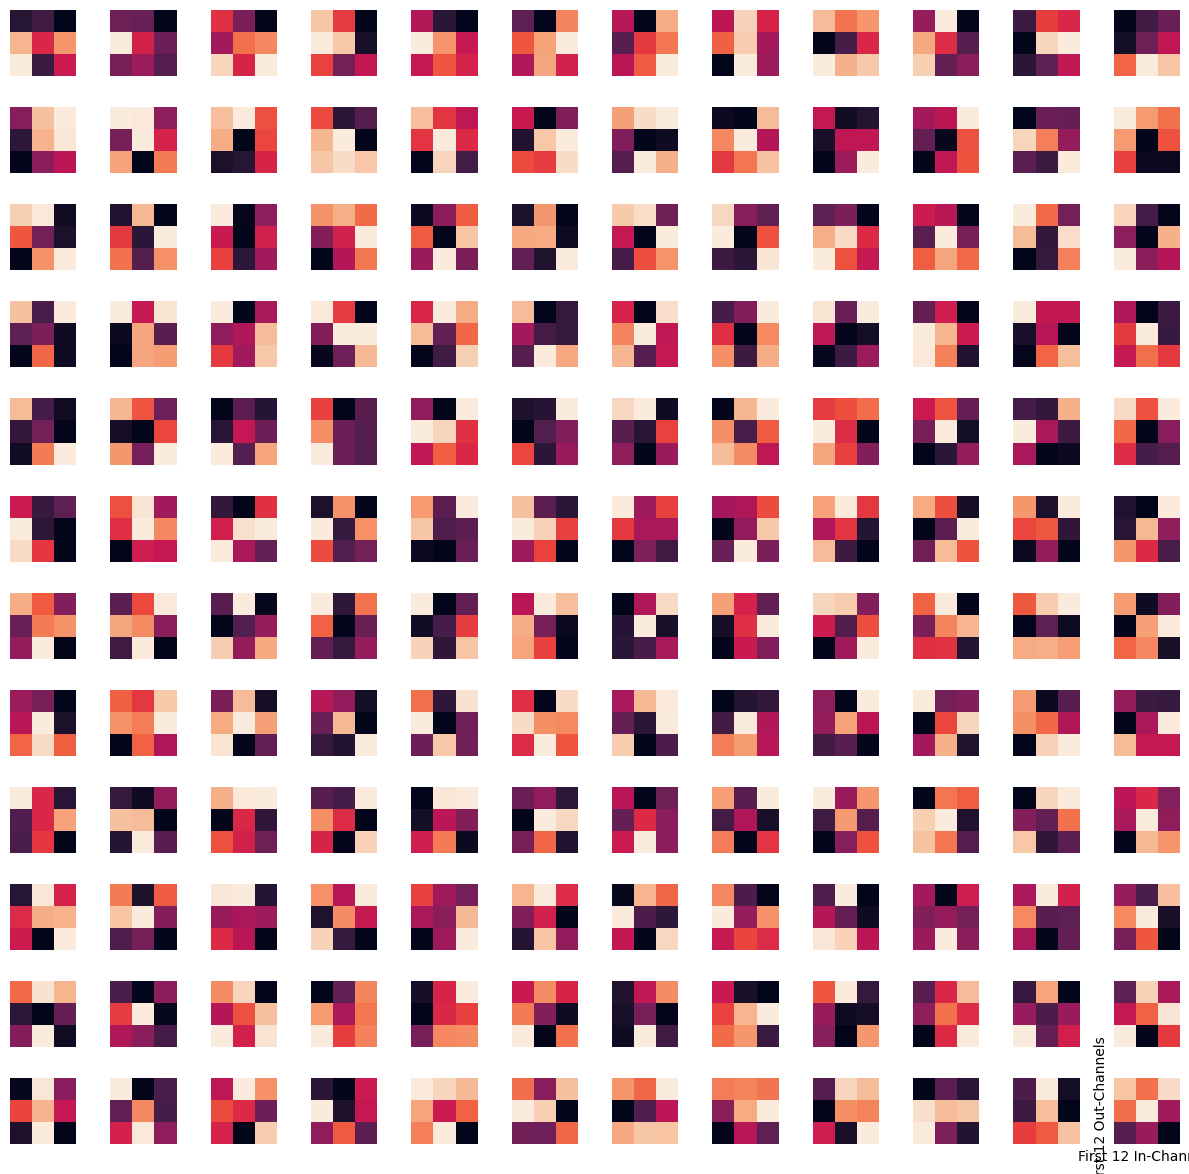

Visualizing the learned filters of `Conv Layer 4`


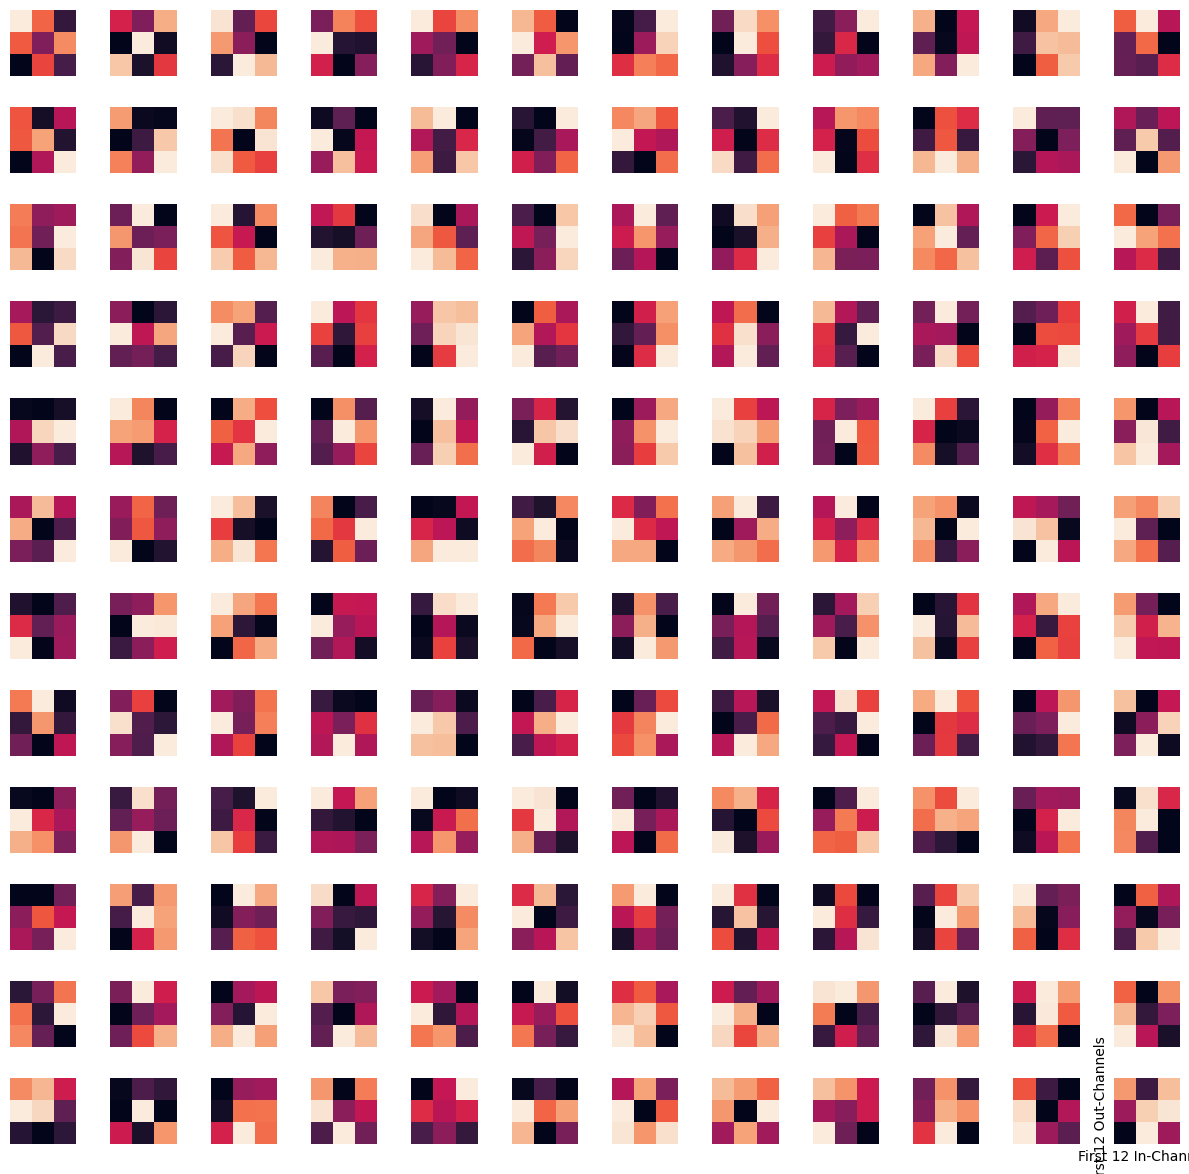

Visualizing the learned filters of `Conv Layer 5`


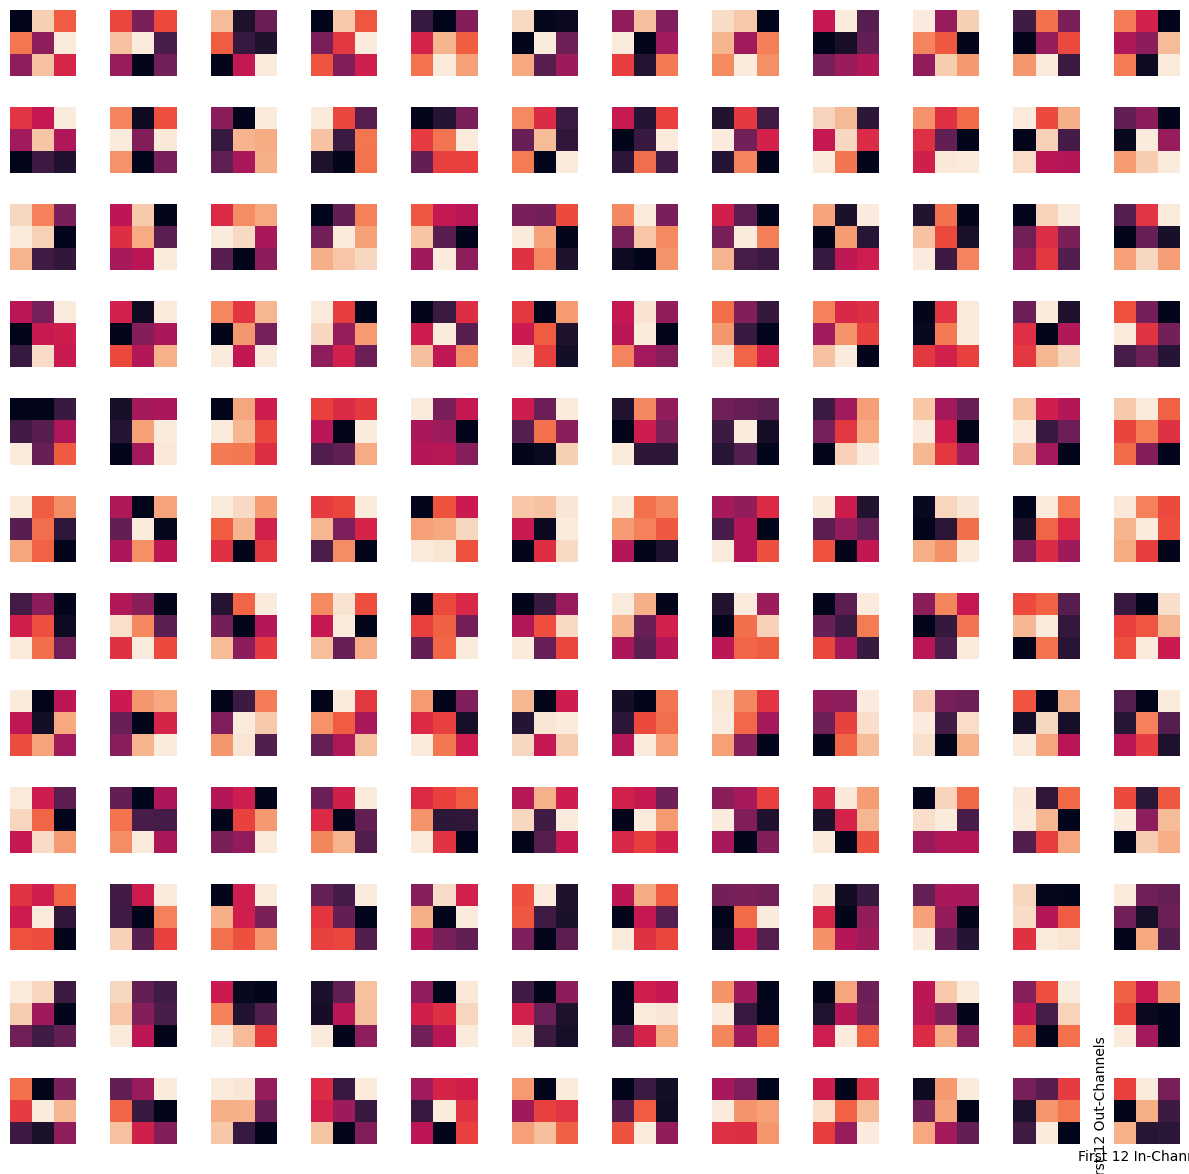

In [25]:
def analyze_model_kernels_pooling(model_checkpoint_path, num_classes):
    # Load the trained model checkpoint
    checkpoint = torch.load(model_checkpoint_path)

    # Assume the model is an instance of AlexNet or a subclass of it with the same architecture
    model = AlexNetAvgPooling(num_classes)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Extract the kernels from the convolutional layers
    kernels = [model.features[i].weight.data for i in range(len(model.features)) if isinstance(model.features[i], nn.Conv2d)]

    # Use the provided visualization helper function to visualize the kernels
    for i, kernel in enumerate(kernels):
        visualize_kernels(f"Conv Layer {i+1}", kernel)

print("AlexNetAvgPooling")
analyze_model_kernels('/content/pacs_dataset/AlexNetAvgPooling.pth', num_classes)